# A product basket optimization approach using Markowitz Portfolio Theory on Vinted dataset

### Introduction to Modern Portfolio Theory

Modern Portfolio Theory (MPT), introduced by Harry Markowitz in 1952, is a mathematical framework for constructing efficient investment portfolios. MPT is based on the idea that investors can construct portfolios that optimize expected return while minimizing risk.

The efficient frontier represents the set of portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of expected return.

### Key Assumptions

- **Defining expected return**: The expected return of a portfolio is the weighted average of the expected returns of its individual assets.

$E(R_p) = \sum_{i=1}^{n} w_i \cdot E(R_i)$

Where:
    - $E(R_p)$ is the expected return of the portfolio.
    - $w_i$ is the weight of asset \(i\) in the portfolio.
    - $E(R_i)$ is the expected return of asset $i$.

- **Defining risk**: The proxy of risk in MPT is the variance of the portfolio.

- **Diversification**: One of the key principles of MPT is diversification, which involves spreading investments across different asset classes with uncorrelated or negatively correlated returns.

### Mathematical Formulation

The optimization problem in MPT can be formulated as a quadratic programming problem to find the optimal portfolio weights that maximize the expected return for a given level of risk or minimize the risk for a given level of expected return, subject to certain constraints such as budget constraints and minimum or maximum weight constraints.

$\text{Maximize} \quad E(R_p) = \mathbf{w}^T \mathbf{R}$

$
\text{Subject to:} \quad
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1 & \text{(Budget constraint)} \\
\mathbf{w}^T \mathbf{\Sigma} \mathbf{w} \leq \sigma^2 & \text{(Risk constraint)} \\
w_i \geq 0 & \text{(Non-negativity constraint)}
\end{cases}
$

Where:
- $E(R_p)$ is the expected return of the portfolio.
- $\mathbf{w}$ is the vector of portfolio weights.
- $\mathbf{R}$ is the vector of expected returns of the assets.
- $\mathbf{\Sigma}$ is the covariance matrix of asset returns.
- $\sigma^2$ is the target risk level.



In [18]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import plotly.io as pio
from plotly.offline import init_notebook_mode
pio.renderers.default = 'iframe'

init_notebook_mode(connected=True)

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""
               WITH catalogs AS (
               SELECT catalog_id
               FROM public.tracking_staging
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               GROUP BY catalog_id
               HAVING COUNT(DISTINCT date) > 5
                    AND COUNT(DISTINCT date) > {time_interval * 0.35}
               )
               SELECT PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY price_numeric) as price, catalog_id, date
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
                    AND catalog_id IN (SELECT catalog_id FROM catalogs)
               GROUP BY date, catalog_id
               """
data = pd.read_sql(sql_query, engine)
#data.index = data.date
data

,price,catalog_id,date
0,5,221,2024-01-28
1,30,560,2024-01-28
2,40,1242,2024-01-28
3,35,1467,2024-01-28
4,7,1801,2024-01-28
...,...,...,...
20831,10,2955,2024-04-12
20832,25,2956,2024-04-12
20833,100,2960,2024-04-12
20834,10,2964,2024-04-12


Loading the melted dataframe into memory. 

Notice I used a CTE to select catalogs with meaningful representation (a minimum number of days threshold).

These are the products we are going to analyze. Each product has a different selling price and volatility, as prices and quantities sold can vary accross time. For this first analyzes, the proxies of returns and risk we are using are product expected price and product price standard deviation.

In [19]:
data = data.pivot_table(index = "date", columns="catalog_id", values = "price")
data.head(10)

catalog_id,11,14,16,18,19,20,22,26,83,84,86,87,88,89,91,92,94,96,97,98,99,119,120,123,124,141,145,152,153,156,157,158,159,160,161,162,163,164,165,166,...,2696,2697,2698,2702,2705,2707,2708,2714,2718,2719,2726,2728,2729,2735,2745,2750,2751,2753,2920,2922,2924,2927,2928,2929,2931,2934,2938,2942,2949,2950,2951,2952,2953,2954,2955,2956,2960,2964,2969,2970
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
2024-02-10,NaN,3.0,NaN,12.0,NaN,7.0,30.0,5.0,5.0,NaN,NaN,9.0,NaN,3.0,NaN,NaN,NaN,NaN,8.0,70.0,5.0,3.0,NaN,5.0,2.0,5.0,NaN,NaN,2.0,30.0,90.0,5.0,NaN,15.0,NaN,5.0,15.0,25.0,6.0,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,15.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,35.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0
2024-02-11,5.0,5.0,5.0,4.0,6.0,4.0,23.0,8.0,14.0,5.0,5.0,9.0,1.0,3.0,10.0,23.0,35.0,5.0,35.0,70.0,4.0,4.0,13.0,5.0,3.0,5.0,16.0,20.0,2.0,13.0,7.0,7.0,6.0,10.0,5.0,5.0,5.0,5.0,5.0,10.0,...,10.0,NaN,4.0,2.0,4.0,4.0,NaN,NaN,15.0,15.0,15.0,4.0,13.0,90.0,15.0,5.0,10.0,NaN,4.0,NaN,5.0,8.0,NaN,4.0,2.0,8.0,9.0,NaN,6.0,NaN,16.0,10.0,3.0,12.0,6.0,2.0,7.0,5.0,8.0,4.0
2024-02-14,NaN,NaN,NaN,12.0,NaN,8.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,35.0,89.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2024-02-15,5.0,5.0,30.0,4.0,4.0,5.0,25.0,25.0,8.0,5.0,5.0,9.0,3.0,2.0,10.0,20.0,35.0,5.0,35.0,80.0,4.0,3.0,4.0,5.0,3.0,NaN,5.0,10.0,2.0,12.0,7.0,7.0,8.0,5.0,5.0,5.0,5.0,4.0,4.0,8.0,...,10.0,NaN,4.0,NaN,3.0,4.0,NaN,NaN,8.0,20.0,15.0,4.0,13.0,NaN,15.0,5.0,10.0,NaN,4.0,NaN,5.0,8.0,5.0,3.0,2.0,2.0,35.0,NaN,8.0,NaN,20.0,10.0,NaN,15.0,5.0,2.0,7.0,NaN,7.0,NaN
2024-02-18,5.0,3.0,10.0,8.0,7.0,5.0,8.0,49.0,15.0,55.0,12.0,8.0,5.0,10.0,NaN,15.0,6.0,12.0,30.0,65.0,10.0,5.0,5.0,5.0,4.0,12.0,15.0,20.0,NaN,10.0,15.0,18.0,12.0,10.0,1.0,2.0,5.0,4.0,4.0,5.0,...,5.0,7.0,4.0,4.0,3.0,2.0,3.0,NaN,7.0,5.0,17.0,7.0,5.0,20.0,4.0,6.0,10.0,3.0,NaN,2.0,5.0,5.0,1.0,5.0,3.0,4.0,35.0,130.0,10.0,4.0,18.0,6.0,3.0,20.0,16.0,10.0,10.0,12.0,15.0,30.0
2024-02-19,5.0,3.0,22.0,5.0,5.0,5.0,15.0,49.0,6.0,8.0,5.0,12.0,2.0,5.0,5.0,15.0,5.0,75.0,40.0,65.0,10.0,6.0,13.0,4.0,5.0,9.0,10.0,10.0,3.0,10.0,15.0,15.0,10.0,10.0,1.0,2.0,3.0,4.0,5.0,8.0,...,15.0,3.0,8.0,4.0,5.0,2.0,3.0,15.0,5.0,6.0,16.0,4.0,4.0,15.0,2.0,20.0,8.0,3.0,5.0,2.0,5.0,5.0,1.0,5.0,8.0,5.0,NaN,20.0,10.0,4.0,17.0,10.0,3.0,18.0,12.0,15.0,100.0,18.0,15.0,30.0
2024-02-20,5.0,3.0,15.0,6.0,7.0,7.0,20.0,40.0,12.0,16.0,6.0,6.0,5.0,3.0,25.0,15.0,6.0,30.0,50.0,55.0,12.0,4.0,5.0,4.0,4.0,9.0,15.0,5.0,4.0,10.0,15.0,10.0,9.0,5.0,1.0,1.0,3.0,4.0,5.0,5.0,...,10.0,7.0,4.0,4.0,7.0,2.0,4.0,15.0,7.0,10.0,16.0,7.0,2.0,5.0,2.0,9.0,8.0,5.0,5.0,2.0,5.0,5.0,10.0,5.0,5.0,10.0,NaN,10.0,10.0,5.0,15.0,8.0,9.0,15.0,12.0,7.0,10.0,15.0,37.0,30.0


Notice there are several periods with no data for some products. We shall assume the median value in order to reduce central moments bias.

Text(0, 0.5, 'returns')

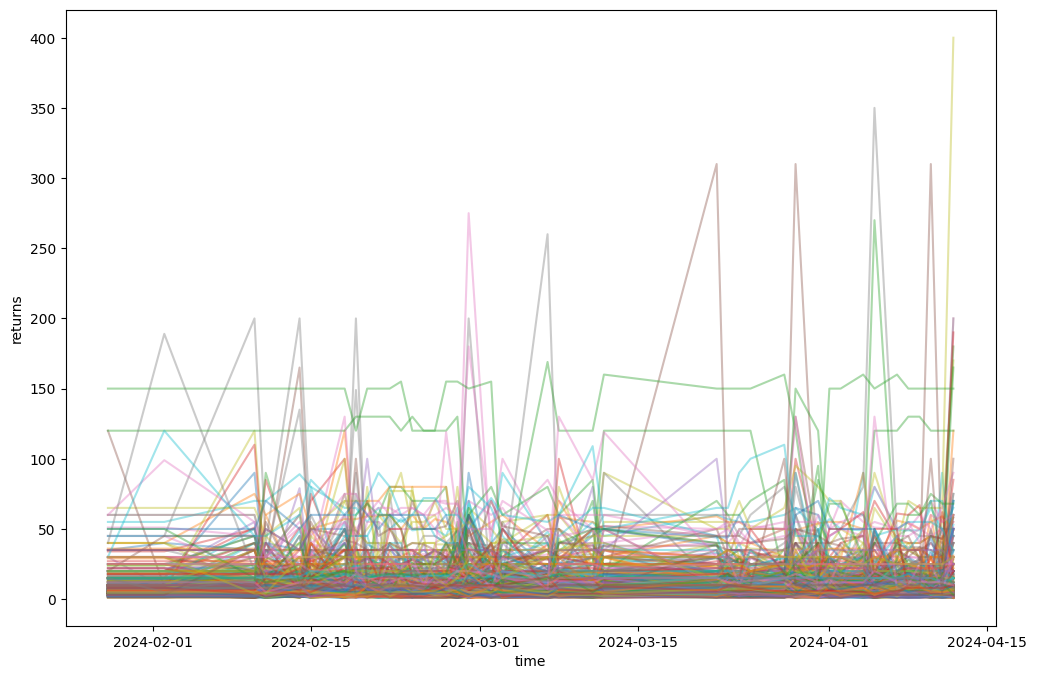

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')


for col in data.columns:
    data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))

plt.figure(figsize=(12, 8))
plt.plot(data, alpha=.4)
plt.xlabel('time')
plt.ylabel('returns')

Lets create several sample portfolios using the MPT formula and a generator function.

In [21]:
var_matrix = data.cov()

num_assets = len(data.columns)
num_port = 5000

port_weights = []
port_returns = []
port_volatility = []

# generator function, creates an iterator over the number of portfolios we want to generate
# its a better practice, specially if num_port -> inf
def generate_random_portfolios(num_port):
    num_assets = len(data.columns)
    var_matrix = data.cov()

    for _ in range(num_port):
        # each asset has either value 0 or 1
        weights = np.random.randint(0, 2, size=num_assets)
        # the returns of the portfolio is the matrix multiplication between (weights,)*(,expected_returns)
        returns = np.dot(weights, data.median())
        # portfolio variance is the double sum of covariance between assets as in the formula
        var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        std = np.sqrt(var)

        yield weights, returns, std

for weights, returns, volatility in generate_random_portfolios(num_port):
    port_weights.append(weights)
    port_returns.append(returns)
    port_volatility.append(volatility)

In [22]:
new_data = {"Revenue": port_returns, 
            "Volatility": port_volatility}

for counter, symbol in enumerate(data.columns.tolist()):
    new_data[str(symbol)+'_weight'] = [w[counter] for w in port_weights]

portfolio = pd.DataFrame(new_data)
portfolio.head(10)

,Revenue,Volatility,11_weight,14_weight,16_weight,18_weight,19_weight,20_weight,22_weight,26_weight,83_weight,84_weight,86_weight,87_weight,88_weight,89_weight,91_weight,92_weight,94_weight,96_weight,97_weight,98_weight,99_weight,119_weight,120_weight,123_weight,124_weight,141_weight,145_weight,152_weight,153_weight,156_weight,157_weight,158_weight,159_weight,160_weight,161_weight,162_weight,163_weight,164_weight,...,2696_weight,2697_weight,2698_weight,2702_weight,2705_weight,2707_weight,2708_weight,2714_weight,2718_weight,2719_weight,2726_weight,2728_weight,2729_weight,2735_weight,2745_weight,2750_weight,2751_weight,2753_weight,2920_weight,2922_weight,2924_weight,2927_weight,2928_weight,2929_weight,2931_weight,2934_weight,2938_weight,2942_weight,2949_weight,2950_weight,2951_weight,2952_weight,2953_weight,2954_weight,2955_weight,2956_weight,2960_weight,2964_weight,2969_weight,2970_weight
0,2861.0,288.379009,1,1,0,1,0,0,1,0,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,1,1,0,0,0,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1,0,1
1,3074.5,223.501572,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,1,0,1,1,0,1,1,...,1,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,1,1,0,0
2,3006.5,287.526227,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,1,0,1,1,...,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,0,1
3,3225.0,247.764758,0,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,...,1,0,0,1,0,1,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,1
4,2888.0,299.575390,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,...,1,0,1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1,1,0,1,0,0,0,1,0,0,1,1,0
5,3185.0,315.407764,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,...,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,1
6,3142.5,338.487883,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,0,0,1,1,1,0,1,1,0,1,...,1,1,0,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,1,1,1
7,3540.5,280.015843,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,1,1,1,1,0,1,1,0,1,0,0,1,0,1,0,...,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,1
8,3087.0,334.492135,0,0,0,0,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1,1,1,0,0,1
9,3252.5,277.542390,1,1,0,1,1,1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,...,1,0,1,1,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,1


In [23]:
# Create heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).values,
    x=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).columns,
    y=portfolio.drop(columns=["Revenue", "Volatility"], axis = 1).head(50).index,
    colorscale='YlGnBu',
    colorbar=dict(title='Number of products')
))

fig.update_layout(
    title='Sparse matrix (product distribution across portfolios)',
    xaxis_title='Catalog_id',
    yaxis_title='Number of sample portfolios'
)
fig


In [24]:
portfolio["Sharpe"] = portfolio["Revenue"]/portfolio["Volatility"]

fig = px.scatter(
    data_frame=portfolio,
    x='Volatility',
    y='Revenue',
    color='Sharpe',
    title='Scatter Plot of Portfolio',
    labels={'Volatility': 'Volatility (std)', 'Revenue': 'Expected Returns', 'Sharpe': 'Sharpe Ratio'},
    marginal_x='histogram',
    marginal_y='histogram', 
)

fig.update_layout(
    width=1200,  
    height=800,  
)

fig


In [25]:
histogram_trace = go.Histogram(
    x=portfolio['Sharpe'],  # 'column_name' contains the data you want to plot
    marker_color='skyblue',  # Optional: set color of bars
    opacity=0.7,  # Optional: set opacity of bars
)


layout = go.Layout(
    title='Distribution Plot',  # Set title of the plot
    xaxis=dict(title='Sharpe'),  # Set label for x-axis
    yaxis=dict(title='Frequency'),  # Set label for y-axis
)

fig = go.Figure(data=[histogram_trace], layout=layout)
fig

In [26]:
z = portfolio.drop(["Volatility", "Revenue", "Sharpe"], axis=1).sum(axis = 1)

fig = px.scatter(
    data_frame=portfolio,
    x=z,
    y='Revenue',
    color='Sharpe',
    title='Revenue per Number of Articles',
    labels={'Volatility': 'Volatility (std)', 'Revenue': 'Expected Returns', 'Sharpe': 'Sharpe Ratio'}
)

fig.update_layout(
    width=1200,
    height=800,
)

fig

In [27]:
scatter3d_trace = go.Scatter3d(
    x=portfolio["Volatility"],
    y=portfolio["Revenue"],
    z=portfolio["Sharpe"],
    mode='markers',
    marker=dict(
        size=4,                    
        color=portfolio["Sharpe"],                   
        colorscale='Viridis',      
        opacity=0.8,
        line=dict(width=0.5, color='black') 
    )
)

layout = go.Layout(
    title='Sharpe curve',
    scene=dict(
        xaxis=dict(title='Volatility'),
        yaxis=dict(title='Revenue'),
        zaxis=dict(title='Sharpe')
    )
)

fig = go.Figure(data=[scatter3d_trace], layout=layout)

fig.update_layout(
    width=1200,  
    height=800,  
    scene=dict(
        xaxis=dict(title='Volatility €', tickfont=dict(size=10)),  # Adjust axis label font size
        yaxis=dict(title='Revenue €', tickfont=dict(size=10)),      # Adjust axis label font size
        zaxis=dict(title='Sharpe', tickfont=dict(size=10)),  # Adjust axis label font size
        camera_eye=dict(x=1.2, y=1.2, z=1.2)  # Adjust camera position
    ),
)
fig

## Analysis of results

In [28]:
top_5_port = portfolio.sort_values("Sharpe", ascending=False).reset_index(drop= True).head(5)
top_5_port

,Revenue,Volatility,11_weight,14_weight,16_weight,18_weight,19_weight,20_weight,22_weight,26_weight,83_weight,84_weight,86_weight,87_weight,88_weight,89_weight,91_weight,92_weight,94_weight,96_weight,97_weight,98_weight,99_weight,119_weight,120_weight,123_weight,124_weight,141_weight,145_weight,152_weight,153_weight,156_weight,157_weight,158_weight,159_weight,160_weight,161_weight,162_weight,163_weight,164_weight,...,2697_weight,2698_weight,2702_weight,2705_weight,2707_weight,2708_weight,2714_weight,2718_weight,2719_weight,2726_weight,2728_weight,2729_weight,2735_weight,2745_weight,2750_weight,2751_weight,2753_weight,2920_weight,2922_weight,2924_weight,2927_weight,2928_weight,2929_weight,2931_weight,2934_weight,2938_weight,2942_weight,2949_weight,2950_weight,2951_weight,2952_weight,2953_weight,2954_weight,2955_weight,2956_weight,2960_weight,2964_weight,2969_weight,2970_weight,Sharpe
0,3083.0,136.697669,0,0,1,1,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,1,...,0,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,1,1,1,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,22.553420
1,2674.0,141.035152,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,0,0,18.959812
2,2955.0,156.259280,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,...,1,1,0,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,18.910877
3,2867.0,155.915403,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,1,1,...,1,0,0,1,1,1,1,0,1,0,1,0,1,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0,18.388177
4,3127.5,171.542679,0,1,1,1,0,1,0,1,0,0,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,...,1,1,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,18.231615


In [29]:
# Create heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).values,
    x=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).columns,
    y=top_5_port.drop(columns=["Revenue", "Volatility", "Sharpe"], axis = 1).index,
    colorscale='YlGnBu',
    colorbar=dict(title='Number of products')
))

fig.update_layout(
    title='Top 5 portfolio composition',
    xaxis_title='Catalog_id',
    yaxis_title='Index'
)
fig

In [30]:
statistics = portfolio[["Revenue", "Volatility", "Sharpe"]].describe()

# Style the DataFrame
styled_statistics = statistics.style \
    .format("{:.2f}") \
    .set_caption("Statistics for Portfolio") \
    .set_table_styles([{'selector': 'caption', 'props': [('color', 'red'), ('font-size', '16px')]}]) 

styled_statistics

line_returns = top_5_port.drop([["Revenue", "Volatility", "Sharpe"]], axis = 1)[0]
line_returns


,Revenue,Volatility,Sharpe
count,5000.00,5000.00,5000.00
mean,2975.98,264.12,11.47
std,190.79,37.96,1.63
min,2261.50,136.70,7.51
25%,2849.00,237.79,10.31
50%,2974.75,263.60,11.28
75%,3107.00,290.17,12.41
max,3608.00,408.00,22.55


# Benchmarking

Creating a portfolio with all products = 1 (market portfolio)

In [31]:
from scipy.stats import linregress

# benchmarking

weights = np.random.randint(1, 2, size=num_assets)
# the returns of the portfolio is the matrix multiplication between (weights,)*(,expected_returns)
returns = np.dot(weights, data.median())
# portfolio variance is the double sum of covariance between assets as in the formula
var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
std = np.sqrt(var)
sharpe = returns/std

print(f"Baseline portfolio performance: \nReturns {returns}\nRisk {std}\nSharpe {sharpe}")

Baseline portfolio performance: 
Returns 5949.0
Risk 483.1022303188264
Sharpe 12.31416380767673


In [32]:
benchmark = pd.DataFrame()
benchmark["Revenue"] = portfolio["Revenue"]/returns
benchmark["Volatility"] = portfolio["Volatility"]/std
benchmark["Sharpe"] = portfolio["Sharpe"]/sharpe

benchmark

,Revenue,Volatility,Sharpe
0,0.480921,0.596932,0.805655
1,0.516810,0.462638,1.117092
2,0.505379,0.595166,0.849139
3,0.542108,0.512862,1.057025
4,0.485460,0.620108,0.782864
...,...,...,...
4995,0.489746,0.693057,0.706646
4996,0.468566,0.458707,1.021493
4997,0.485040,0.487021,0.995931
4998,0.439654,0.487529,0.901800


In [33]:
fig = px.scatter(
    data_frame=benchmark[benchmark["Sharpe"] > 1],
    x='Volatility',
    y='Revenue',
    color='Sharpe',
    title='Scatter Plot of Portfolio',
    labels={'Volatility': 'Volatility (std)', 'Revenue': 'Expected Returns', 'Sharpe': 'Sharpe Ratio'},
    marginal_x='histogram',
    marginal_y='histogram', 
)

fig.update_layout(
    width=1200,  
    height=800,  
)

fig

In [34]:
benchmark[["Revenue", "Volatility", "Sharpe"]].describe()

,Revenue,Volatility,Sharpe
count,5000.000000,5000.000000,5000.000000
mean,0.500249,0.546726,0.931803
std,0.032070,0.078584,0.132446
min,0.380148,0.282958,0.609597
25%,0.478904,0.492221,0.836924
50%,0.500042,0.545632,0.916325
75%,0.522273,0.600646,1.007526
max,0.606488,0.844535,1.831502


catalog_id    18    14
date                  
2024-01-28   6.0   3.0
2024-02-02   6.0   3.0
2024-02-10  12.0   3.0
2024-02-11   4.0   5.0
2024-02-14  12.0   3.0
2024-02-15   4.0   5.0
2024-02-18   8.0   3.0
2024-02-19   5.0   3.0
2024-02-20   6.0   3.0
2024-02-21   6.0   3.0
2024-02-22   6.0   3.0
2024-02-23   6.0   3.0
2024-02-24   6.0   3.0
2024-02-25   6.0   3.0
2024-02-26   6.0   3.0
2024-02-27   8.0   3.0
2024-02-28   6.0   4.0
2024-02-29  10.0  10.0
2024-03-02   7.0   3.0
2024-03-03   5.0   3.0
2024-03-07   5.0   4.0
2024-03-08   5.0   3.0
2024-03-11   5.0   3.0
2024-03-12   8.0   4.0
2024-03-22   5.0   3.0
2024-03-23   5.0   4.0
2024-03-24   5.0   4.0
2024-03-25   5.0   4.0
2024-03-28   6.0   3.0
2024-03-29  10.0   3.0
2024-03-31  10.0   4.0
2024-04-01   6.0   4.0
2024-04-02   8.0   4.0
2024-04-04   5.0   5.0
2024-04-05   5.0  15.0
2024-04-07   5.0   5.0
2024-04-08   5.0   4.0
2024-04-09   5.0   4.0
2024-04-10   5.0   3.0
2024-04-11   5.0   4.0
2024-04-12  10.0   3.0


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



AttributeError: 'int' object has no attribute 'symbol'

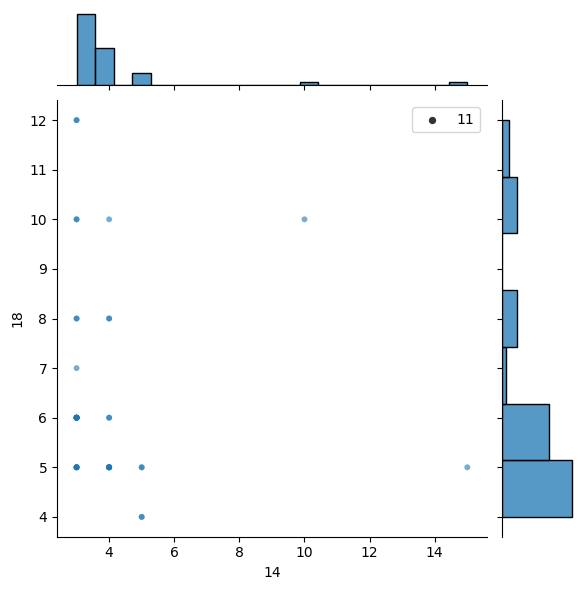

In [35]:

def regression_plot(data, size=11, legend_position='lower right'):
    """Calculate and plot a linear regression between two columns of data.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame with two columns to be regressed and plotted.
        The first column of the frame will be plotted on the y-axis.
        The secont column of the frame will be plotted on the x-axis.  
    figsize : tuple, optional
        Size of the resulting figure in (x_inches, y_inches)
    legend_position : string
        Location on the plot for the legend.
        
    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes containing the scatterplot and regression line.
    """
    ylabel, xlabel = data.columns

    # Draw scatterplot with marginals using seaborn.
    grid = sns.jointplot(x=data[xlabel], y=data[ylabel], 
                         size=size, joint_kws={'alpha': 0.6, 'linewidth': 0})
    
    # The plot generated by seaborn is composed of three matplotlib.Axes objects.
    # The scatter plot is drawn on ax_joint. Draw a regression line on top of the scatter plot.
    axes = grid.ax_joint
    draw_regression_line(Y=data[ylabel], X=data[xlabel], ax=axes)

    # Set X and Y Axis Bounds
    min_ = data.values.min() * 1.05  # Leave a margin at the edge of the figure.
    max_ = data.values.max() * 1.05
    axes.set_ylim(min_, max_)
    axes.set_xlim(min_, max_)

    # Draw legend.
    axes.legend(fontsize=13, loc=legend_position)
    
    # Set title on the overall figure.
    grid.fig.suptitle(
        '{} Returns vs {} Returns'.format(ylabel.symbol, xlabel.symbol),
        size=18, 
        y=1.02
    ) 
    
    # Set axis label sizes.
    axes.set_ylabel(ylabel.symbol, size=15)
    axes.set_xlabel(xlabel.symbol, size=15)

    return axes

def draw_regression_line(Y, X, ax=None):
    """Calculate and plot a linear regression line.

    Parameters
    ----------
    Y : np.array or pd.Series
        Y values for the regression.
    X : np.array or pd.Series
        X values for the regression.
    ax : matplotlib.Axes, optional
        Axes on which to draw the line.
        If not passed, default is ``matplotlib.pyplot.gca()``.
    """
    if ax is None:
        ax = plt.gca()

    result = linregress(x=X, y=Y)
    slope = result.slope
    intercept = result.intercept

    x_endpoints = np.array([X.min(), X.max()]) * 2
    y_endpoints = intercept + slope * x_endpoints

    # Format a regression equation in LaTeX.
    plot_label = "${} = {:.4g}{} {} {:.4g}$".format(
        r'\mathrm{' + Y.name.symbol + '}',
        slope,
        r'\mathrm{' + X.name.symbol + '}',
        '+' if intercept > 0 else '-',
        abs(intercept),
    )

    ax.plot(x_endpoints, y_endpoints, label=plot_label, linestyle='--', color='red', linewidth=2)
    return ax

print(data.reset_index().set_index("date")[[18, 14]])
regression_plot(data.reset_index().set_index("date")[[18, 14]])

In [40]:
from sklearn.linear_model import LinearRegression

#print(portfolio)
reg = LinearRegression().fit(portfolio.drop(["Sharpe", "Revenue", "Volatility"], axis = 1), portfolio["Sharpe"])
coefficients = reg.coef_
top_5_indices = coefficients.argsort()[-10:][::-1]

# Get the corresponding labels
top_5_labels = portfolio.columns[top_5_indices]
for coef, label in zip(coefficients[top_5_indices], top_5_labels):
    print(f"{label}: {coef}")

2663_weight: 0.519356350867977
2648_weight: 0.42055619771153246
2537_weight: 0.34305256380366206
2533_weight: 0.28771318342111735
1443_weight: 0.2573125124443303
2531_weight: 0.2568108034716538
2532_weight: 0.24412310700707796
2677_weight: 0.22216924485849263
2535_weight: 0.21868287381319748
1231_weight: 0.21863562758671523
